# Final project

## Pre processing 


### Importer

In [50]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [51]:
print(np.__version__)

1.26.4


### Loading labled data (laspy)


In [52]:
import laspy

# Path to your LAS file
file_path = "data/cloud_final_kopi.las"

# Open the LAS file and inspect the header
with laspy.open(file_path) as f:
    las = f.read()
    header = f.header

    # Print scale and offset (defines coordinate system precision)
    print("Scale factors (units per coordinate step):")
    print(f"X scale: {header.scale[0]}")
    print(f"Y scale: {header.scale[1]}")
    print(f"Z scale: {header.scale[2]}")

    print("\nOffsets (origin of coordinates):")
    print(f"X offset: {header.offset[0]}")
    print(f"Y offset: {header.offset[1]}")
    print(f"Z offset: {header.offset[2]}")

    # Estimate the range of coordinates
    x_min, y_min, z_min = las.x.min(), las.y.min(), las.z.min()
    x_max, y_max, z_max = las.x.max(), las.y.max(), las.z.max()

    print("\nBounding box (min and max coordinates):")
    print(f"X range: {x_min} to {x_max}")
    print(f"Y range: {y_min} to {y_max}")
    print(f"Z range: {z_min} to {z_max}")

    # Assume the coordinates are in meters if the CRS is known
    print("\nAssume units in meters if the CRS is georeferenced (e.g., UTM).")

Scale factors (units per coordinate step):
X scale: 0.01
Y scale: 0.01
Z scale: 0.01

Offsets (origin of coordinates):
X offset: 569000.0
Y offset: 7022000.0
Z offset: -0.0

Bounding box (min and max coordinates):
X range: 568800.01 to 569268.58
Y range: 7022123.91 to 7022399.99
Z range: 157.44 to 232.39000000000001

Assume units in meters if the CRS is georeferenced (e.g., UTM).


In [53]:
# Step 1: Load Point Cloud
file_path = "data/cloud_final_kopi.las"

with laspy.open(file_path) as f:
    las = f.read()
    total_points = len(las.points)

    points = las.points

    data = {
        'x': points['X'] * las.header.scale[0] + las.header.offset[0],
        'y': points['Y'] * las.header.scale[1] + las.header.offset[1],
        'z': points['Z'] * las.header.scale[2] + las.header.offset[2],
        'classification': points['classification'],
        'intensity': points['intensity']
    }
    df = pd.DataFrame(data)

In [54]:
df.head()
df['classification'].unique()

array([5, 3, 8, 2, 7, 4, 9, 1], dtype=uint8)

### Bestmme voxel strl.

In [55]:
voxel_size = 4

In [56]:
voxel_size = 4
points = df[['x', 'y', 'z']].values
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)



### Details

In [57]:
# Bounding box for splitting
x_min, y_min, z_min = df[['x', 'y', 'z']].min()
x_max, y_max, z_max = df[['x', 'y', 'z']].max()

# Diagonal line parameters
b = y_min - x_min  # Intercept
m = 1  # Slope (diagonal line)

offset = (y_max - y_min) * -0.1  # Adjust this to shift the diagonal lower, e.g., 10% of the y-axis range
threshold_factor=0

In [58]:
#o3d.visualization.draw_geometries([voxel_grid], window_name="Voxel Grid Visualization", width=800, height=600)
#o3d.visualization.Visualizer().destroy_window()
print("Voxel size:", voxel_size)
print("Number of voxels:", len(voxel_grid.get_voxels()))


Voxel size: 4
Number of voxels: 16491


In [59]:
# Step 4: Calculate features for each voxel
voxel_features = {}
training_indices = []
test_indices = []


In [60]:
# Helper function to check location relative to modified diagonal
def is_below_modified_diagonal(x, y):
    """Check if a point is below the modified diagonal line with extra bias towards bottom-left corner."""
    # Adjust the condition to make the diagonal further down by adding an offset to the y-values
    return (y <= m * x + (b + offset)) or (x <= x_min + (x_max - x_min) * threshold_factor and y <= y_min + (y_max - y_min) * threshold_factor)



### Calculations

In [61]:

# Step 1: Define feature and residual calculation functions
def fit_plane(points):
    """Fit a plane to points in 3D using PCA and return the normal and centroid."""
    pca = PCA(n_components=3)
    pca.fit(points)
    normal_vector = pca.components_[0]  # Normal vector of the plane (first principal component)
    centroid = np.mean(points, axis=0)  # Centroid of the points
    return normal_vector, centroid


def calculate_orthogonal_distances(points, normal_vector, centroid):
    """Calculate the orthogonal distances of points to a plane defined by a normal and centroid."""
    distances = np.abs((points - centroid).dot(normal_vector))  # Orthogonal distance to the plane
    return distances


def calculate_residual(distances):
    """Calculate the residual value as the root mean square of orthogonal distances."""
    residual = np.sqrt(np.mean(distances ** 2))  # Root mean square of distances
    return residual


def calculate_features(eigenvalues):
    """Calculate the features based on eigenvalues λ1, λ2, and λ3."""
    λ1, λ2, λ3 = eigenvalues
    
    # Compute features
    linearity = (λ1 - λ2) / λ1
    planarity = (λ2 - λ3) / λ1
    scattering = λ3 / λ1
    omnivariance = (λ1 * λ2 * λ3) ** (1/3)
    sum_of_eigenvalues = λ1 + λ2 + λ3
    anisotropy = (λ1 - λ3) / λ1
    eigenentropy = -np.sum([λ * np.log(λ) for λ in eigenvalues if λ > 0])  # Ignore non-positive eigenvalues in log
    change_of_curvature = λ3 / sum_of_eigenvalues

    return {
        "linearity": linearity,
        "planarity": planarity,
        "scattering": scattering,
        "omnivariance": omnivariance,
        "sum_of_eigenvalues": sum_of_eigenvalues,
        "anisotropy": anisotropy,
        "eigenentropy": eigenentropy,
        "change_of_curvature": change_of_curvature
    }


### Main 

In [62]:
from collections import Counter
from sklearn.decomposition import PCA

total_voxels = 0
voxels_with_few_points = 0
voxels_all_nan = 0
processed_voxels = 0

# Iterate over each voxel in the voxel grid
for voxel in voxel_grid.get_voxels():
    total_voxels += 1
    voxel_center = voxel.grid_index
    min_bound = np.array(voxel_grid.origin) + np.array(voxel_center) * voxel_size
    max_bound = min_bound + voxel_size
    points_in_voxel = df[(df['x'] >= min_bound[0]) & (df['x'] < max_bound[0]) &
                         (df['y'] >= min_bound[1]) & (df['y'] < max_bound[1]) &
                         (df['z'] >= min_bound[2]) & (df['z'] < max_bound[2])]

    if len(points_in_voxel) < 3:
        voxels_with_few_points += 1
        continue

    # Handle NaN values
    valid_classifications = points_in_voxel['classification'].dropna()
    
    if len(valid_classifications) == 0:
        voxels_all_nan += 1
        continue

    # If we reach here, we have a voxel with enough points and at least one valid classification
    processed_voxels += 1
    
    # Rest of the processing (feature extraction, etc.) remains the same
    most_common_class = Counter(valid_classifications).most_common(1)[0][0]
    
    # Fit a plane and calculate residual
    normal_vector, centroid = fit_plane(points_in_voxel[['x', 'y', 'z']].values)
    distances = calculate_orthogonal_distances(points_in_voxel[['x', 'y', 'z']].values, normal_vector, centroid)
    residual = calculate_residual(distances)

    # Compute features
    pca = PCA(n_components=3)
    pca.fit(points_in_voxel[['x', 'y', 'z']].values)
    eigenvalues = np.sort(pca.explained_variance_)[::-1]
    features = calculate_features(eigenvalues)
    features["residual"] = residual
    features["classification"] = most_common_class

    # Determine split
    voxel_center_coords = min_bound + voxel_size / 2
    if is_below_modified_diagonal(voxel_center_coords[0], voxel_center_coords[1]):
        training_indices.append(tuple(voxel.grid_index))
    else:
        test_indices.append(tuple(voxel.grid_index))

    voxel_features[tuple(voxel.grid_index)] = features

# After processing all voxels, print summary statistics
print(f"Total voxels: {total_voxels}")
print(f"Voxels with fewer than 3 points: {voxels_with_few_points}")
print(f"Voxels with all NaN classifications: {voxels_all_nan}")
print(f"Processed voxels: {processed_voxels}")

# Create DataFrame and check for NaN classifications
features_df = pd.DataFrame.from_dict(voxel_features, orient='index')
print(f"Number of voxels with NaN classifications after feature extraction: {features_df['classification'].isna().sum()}")
print(f"Number of voxels with classifications after feature extraction: {len(features_df)}")

# Calculate and print the number of voxels without classification
voxels_without_classification = total_voxels - len(features_df)
print(f"Number of voxels without classification: {voxels_without_classification}")

Total voxels: 16491
Voxels with fewer than 3 points: 575
Voxels with all NaN classifications: 0
Processed voxels: 15916
Number of voxels with NaN classifications after feature extraction: 0
Number of voxels with classifications after feature extraction: 15916
Number of voxels without classification: 575


In [167]:
def save_voxel_data_to_csv(voxel_features, output_csv_path):
    # Create DataFrame from voxel features
    df = pd.DataFrame.from_dict(voxel_features, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'voxel_index'}, inplace=True)
    
    # Add a column to indicate if the voxel was processed
    df['processed'] = True
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"CSV file saved to: {output_csv_path}")
    
    # Print summary
    print(f"Total voxels: {len(df)}")
    print(f"Processed voxels: {df['processed'].sum()}")
output_csv_path = "voxel_data.csv"
save_voxel_data_to_csv(voxel_features, output_csv_path)

CSV file saved to: voxel_data.csv
Total voxels: 15916
Processed voxels: 15916


In [ ]:
def save_voxel_data_to_csv(voxel_features, output_csv_path):
    # Create DataFrame from voxel features
    df = pd.DataFrame.from_dict(voxel_features, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'voxel_index'}, inplace=True)
    
    # Add a column to indicate if the voxel was processed
    df['processed'] = True
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"CSV file saved to: {output_csv_path}")
    
    # Print summary
    print(f"Total voxels: {len(df)}")
    print(f"Processed voxels: {df['processed'].sum()}")
output_csv_path = "voxel_data.csv"
save_voxel_data_to_csv(voxel_features, output_csv_path)

In [5]:
features_df = pd.read_csv("voxel_data.csv")

In [6]:
features_df['classification'].unique()

array([8, 7, 5, 2, 1, 4, 3, 9])

## Vis not finsish okey

In [ ]:
import open3d as o3d
import numpy as np
from collections import Counter

# Define a color map for the classes (you can expand this if needed)
class_colors = {
    1: [1, 0, 0],    # Red
    8: [0, 1, 0],    # Green
    2: [0, 0, 1],    # Blue
    7: [1, 1, 0],    # Yellow
    5: [1, 0, 1],    # Magenta
    4: [0, 1, 1],    # Cyan
}

# Function to visualize voxel grid with colors based on classification
def visualize_colored_voxels(voxel_grid, voxel_features, voxel_size):
    # Create a point cloud to represent voxel centers
    points = []
    colors = []
    unique_classifications = set()
    classification_count = Counter()
    color_count = Counter()
    voxels_with_classification = 0
    total_voxels = 0

    for voxel in voxel_grid.get_voxels():
        total_voxels += 1
        voxel_center = voxel.grid_index
        voxel_coords = np.array(voxel_grid.origin) + (np.array(voxel_center) + 0.5) * voxel_size

        # Get the classification for this voxel
        voxel_data = voxel_features.get(tuple(voxel_center))
        if voxel_data and 'classification' in voxel_data:
            classification = voxel_data['classification']
            unique_classifications.add(classification)
            classification_count[classification] += 1
            voxels_with_classification += 1
        else:
            classification = 0  # Default classification if not found

        # Assign color based on classification
        color = tuple(class_colors.get(classification, [0.5, 0.5, 0.5]))  # Default to gray if class not in color map
        color_count[color] += 1

        points.append(voxel_coords)
        colors.append(color)

    print(f"Total number of voxels: {total_voxels}")
    print(f"Number of voxels with classification data: {voxels_with_classification}")
    print(f"Unique classifications found: {unique_classifications}")
    print(f"Classification counts: {dict(classification_count)}")
    print(f"Color counts: {dict(color_count)}")
    print(f"Number of gray voxels: {color_count[(0.5, 0.5, 0.5)]}")

    # Create colored point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Create a voxel grid from the colored point cloud
    colored_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)

    # Visualize the colored voxel grid
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Colored Voxel Grid Visualization", width=800, height=600)
    vis.add_geometry(colored_voxel_grid)
    
    # Set a larger point size for better visibility
    opt = vis.get_render_option()
    opt.point_size = 5.0  # Adjust this value to change the size of the voxels
    
    vis.run()
    vis.destroy_window()

# Assuming you have your voxel_grid, voxel_features, and voxel_size defined
# voxel_grid = ...
# voxel_features = ...
# voxel_size = ...

#visualize_colored_voxels(voxel_grid, voxel_features, voxel_size)

Total number of voxels: 16491
Number of voxels with classification data: 15916
Unique classifications found: {1, 2, 3, 4, 5, 7, 8, 9}
Classification counts: {8: 7582, 7: 4150, 5: 263, 2: 1478, 1: 2389, 4: 35, 3: 5, 9: 14}
Color counts: {(0, 1, 0): 7582, (1, 1, 0): 4150, (1, 0, 1): 263, (0, 0, 1): 1478, (1, 0, 0): 2389, (0.5, 0.5, 0.5): 594, (0, 1, 1): 35}
Number of gray voxels: 594
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [201]:
class_c=features_df['classification'].value_counts()
print(f"Value counts in 'classification':\n{class_c}")


Value counts in 'classification':
classification
8    7582
7    4150
1    2389
2    1478
5     263
4      35
9      14
3       5
Name: count, dtype: int64


## Training 

### Merge classes training


In [7]:
# Define a mapping of old classes to new merged classes
class_mapping = {
    0: 'Buildings',      # Chimney -> Buildings
    1: 'Terrain',        # Low vegetation -> Terrain
    2: 'Terrain',        # Impervious surfaces -> Terrain
    3: 'Cars',           # Car -> Cars
    4: 'Fence',      # Fence/Hedge -> Buildings
    5: 'Buildings',      # Building -> Buildings
    6: 'Terrain',        # Water -> Terrain
    7: 'Terrain',        # Farm/Soil -> Terrain
    8: 'Trees',          # Tree -> Trees
}


In [9]:
df.head()

NameError: name 'df' is not defined

In [10]:
## 1. Transforming class to new class
features_df['new_classification'] = features_df['classification'].map(class_mapping)
print(f"Printed head of features_df after adding new_classification:\n{features_df.head()}")

## 2. Checking the transforming data
class_counts = features_df['new_classification'].value_counts()
print(f"\nValue counts in 'new_classification':\n{class_counts}")

# Check if any 'new_classification' values are missing
nan_count = features_df['new_classification'].isna().sum()
print(f"\nNumber of NaN values in new_classification: {nan_count}")

# Drop voxels with NaN in new_classification
original_count = len(features_df)
features_df = features_df.dropna(subset=['new_classification'])
new_count = len(features_df)
dropped_count = original_count - new_count

print(f"\nNumber of voxels dropped due to NaN in new_classification: {dropped_count}")
print(f"Percentage of voxels dropped: {(dropped_count / original_count) * 100:.2f}%")

# Final check after dropping NaN values
final_class_counts = features_df['new_classification'].value_counts()
print(f"\nFinal value counts in 'new_classification' after dropping NaN:\n{final_class_counts}")

Printed head of features_df after adding new_classification:
   level_0  level_1  level_2  linearity  planarity  scattering  omnivariance  \
0      114       59       11   0.467540   0.359354    0.173107      0.814931   
1       38       53        4   0.929432   0.069575    0.000993      0.014319   
2       36       46        4   0.022983   0.967429    0.009588      0.281591   
3        1       56        4   0.365127   0.563641    0.071232      0.592310   
4       76       25        5   0.249793   0.538930    0.211276      0.676573   

   sum_of_eigenvalues  anisotropy  eigenentropy  change_of_curvature  \
0            3.076964    0.826893     -0.662416             0.101495   
1            0.372132    0.999007      0.460933             0.000927   
2            2.653727    0.990412     -0.678490             0.004826   
3            2.836403    0.928768     -0.649424             0.041751   
4            2.452198    0.788724      0.132637             0.107713   

   residual  classificati

In [75]:
# Define the color mapping for each class
class_colors = {
    'Buildings': [1, 0, 0],  # Red
    'Terrain': [0, 1, 0],    # Green
    'Trees': [0, 0, 1],      # Blue
    'Cars': [1, 1, 0],       # Yellow
    'Fence': [1, 0, 1],      # Magenta
}
# Ensure the DataFrame contains the required columns
if {'level_0', 'level_1', 'level_2', 'new_classification'}.issubset(features_df.columns):
    # Extract voxel positions and predicted classes
    voxel_positions = features_df[['level_0', 'level_1', 'level_2']].values
    new_classification = features_df['new_classification'].values

    # Prepare points and colors for visualization
    points = []
    colors = []

    for pos, pred_class in zip(voxel_positions, new_classification):
        points.append(pos)
        # Assign color based on predicted class
        color = class_colors.get(pred_class, [0.5, 0.5, 0.5])  # Default to gray if class is unknown
        colors.append(color)

    # Create a PointCloud object for visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save the visualized point cloud
    output_path = "/Users/Rebekka/GiHub/3dFinalProject/results/voxel_coloring.ply"
    o3d.io.write_point_cloud(output_path, pcd)
    print(f"Voxel visualization saved to: {output_path}")

    # Visualize the voxels with predicted class colors
    o3d.visualization.draw_geometries([pcd], window_name="Voxel Prediction Visualization", width=800, height=600)

    
else:
    print("The DataFrame must include 'level_0', 'level_1', 'level_2', and 'predicted_class' columns.")



The DataFrame must include 'level_0', 'level_1', 'level_2', and 'predicted_class' columns.


In [74]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming features_df contains 'level_0' (x), 'level_1' (y), and 'new_classification'
x_min = features_df['level_0'].min()
x_max = features_df['level_0'].max()

# Define split threshold as 20% of the horizontal range
split_threshold = x_min + 0.18 * (x_max - x_min)

# Create masks for train and test data based on geographical X-coordinate
test_mask = features_df['level_0'] <= split_threshold
train_mask = ~test_mask

# Split the features and labels
X_train = features_df[train_mask].drop(columns=['new_classification'])
X_test = features_df[test_mask].drop(columns=['new_classification'])
y_train = features_df[train_mask]['new_classification']
y_test = features_df[test_mask]['new_classification']

# Verify the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
#prints
class_counts=features_df['new_classification'].value_counts()
print(f"Value counts in 'new_classification':\n{class_counts}")

print("\n Unique classes in the test set:", y_test.value_counts())
print("\n Unique classes in the training set:", y_train.value_counts())

# Plot the train-test split
plt.figure(figsize=(10, 6))
plt.scatter(features_df.loc[train_mask, 'level_0'], features_df.loc[train_mask, 'level_1'], 
            c='blue', label='Train Set', s=10, alpha=0.5)
plt.scatter(features_df.loc[test_mask, 'level_0'], features_df.loc[test_mask, 'level_1'], 
            c='orange', label='Test Set', s=10, alpha=0.5)
plt.axvline(split_threshold, color='red', linestyle='--', label='Split Threshold')
plt.xlabel('Level_0 (X-coordinate)')
plt.ylabel('Level_1 (Y-coordinate)')
plt.title('Geographical Train-Test Split')
plt.legend()
plt.grid()
plt.show()


KeyError: 'level_0'

In [32]:
# Specify the output file path
output_file = "features_df.csv"

# Save the features_df DataFrame to a CSV file
features_df.to_csv(output_file, index=False)

print(f"The features_df DataFrame has been saved to '{output_file}'")

The features_df DataFrame has been saved to 'features_df.csv'


In [33]:
# Evaluate the model
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Buildings       0.32      0.21      0.26       108
        Cars       0.00      0.00      0.00         2
       Fence       0.00      0.00      0.00        35
     Terrain       0.90      0.88      0.89      1644
       Trees       0.75      0.84      0.79       902

    accuracy                           0.83      2691
   macro avg       0.39      0.39      0.39      2691
weighted avg       0.81      0.83      0.82      2691



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [35]:
test_results_df = X_test.copy()

# Add the ground truth labels
test_results_df['true_class'] = y_test.values

# Add the predicted classes
test_results_df['predicted_class'] = y_pred

# Print a preview of the results
print(test_results_df.head())

    level_0  level_1  level_2  linearity  planarity  scattering  omnivariance  \
3         1       56        4   0.365127   0.563641    0.071232      0.592310   
8         9        4        3   0.561429   0.435971    0.002600      0.045781   
15       11        5        6   0.646597   0.140016    0.213387      0.469900   
19        7       17        4   0.016307   0.981891    0.001802      0.163348   
25        7       19        4   0.023269   0.962434    0.014297      0.322564   

    sum_of_eigenvalues  anisotropy  eigenentropy  change_of_curvature  \
3             2.836403    0.928768     -0.649424             0.041751   
8             0.631532    0.997400      0.686241             0.001804   
15            1.742625    0.786613      0.590091             0.136194   
19            2.679614    0.998198     -0.766162             0.000908   
25            2.666965    0.985703     -0.667376             0.007181   

    residual  processed true_class predicted_class  
3   1.215640       Tr

### vis


In [70]:
import open3d as o3d
import numpy as np


import open3d as o3d
import numpy as np

# Define the color mapping for classes
class_colors = {
    'Buildings_correct': [1, 0.5, 0.5],   # Light Red for correct Buildings
    'Buildings_incorrect': [0.5, 0, 0],   # Dark Red for incorrect Buildings
    'Terrain_correct': [0.5, 1, 0.5],     # Light Green for correct Terrain
    'Terrain_incorrect': [0, 0.5, 0],     # Dark Green for incorrect Terrain
    'Trees_correct': [0.5, 0.5, 1],       # Light Blue for correct Trees
    'Trees_incorrect': [0, 0, 0.5],       # Dark Blue for incorrect Trees
    'Cars_correct': [1, 1, 0.5],          # Light Yellow for correct Cars
    'Cars_incorrect': [0.5, 0.5, 0],      # Dark Yellow for incorrect Cars
    'Fence_correct': [1, 0.5, 1],         # Light Magenta for correct Fence
    'Fence_incorrect': [0.5, 0, 0.5],     # Dark Magenta for incorrect Fence
}

# Ensure the DataFrame contains required columns
if {'level_0', 'level_1', 'level_2', 'predicted_class', 'true_class'}.issubset(test_results_df.columns):
    # Extract voxel positions, predicted classes, and true classes
    voxel_positions = test_results_df[['level_0', 'level_1', 'level_2']].values
    predicted_classes = test_results_df['predicted_class'].values
    true_classes = test_results_df['true_class'].values

    # Prepare points and colors for visualization
    points = []
    colors = []

    for pos, pred_class, true_class in zip(voxel_positions, predicted_classes, true_classes):
        points.append(pos)  # Add voxel center
        if pred_class == true_class:
            key = f"{true_class}_correct"  # Correct prediction color
        else:
            key = f"{true_class}_incorrect"  # Incorrect prediction color
        color = class_colors.get(key, [0.5, 0.5, 0.5])  # Default to gray if class is unknown
        colors.append(color)

    # Convert to numpy arrays
    points = np.array(points)
    colors = np.array(colors)

    # Create a PointCloud object for visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save the visualized point cloud
    output_path = "/Users/Rebekka/GiHub/3dFinalProject/results/detailed_correct_vs_incorrect_voxels.ply"
    o3d.io.write_point_cloud(output_path, pcd)
    print(f"Voxel visualization saved to: {output_path}")

    # Visualize the voxels with detailed correct/incorrect colors
    o3d.visualization.draw_geometries([pcd], window_name="Detailed Voxel Prediction Accuracy Visualization", width=800, height=600)
else:
    print("The DataFrame must include 'level_0', 'level_1', 'level_2', 'predicted_class', and 'true_class' columns.")


Voxel visualization saved to: /Users/Rebekka/GiHub/3dFinalProject/results/detailed_correct_vs_incorrect_voxels.ply
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


KeyboardInterrupt: 


Precision and Recall for each class:
Buildings: Precision = 1.00, Recall = 0.20
Trees: Precision = 0.65, Recall = 0.85
Terrain: Precision = 0.63, Recall = 0.95

Misclassified samples:
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Terrain
True Class: Trees, Predicted Class: Terrain
True Class: Trees, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Terrain
True Class: Trees, Predicted Class: Terrain
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Trees
True Class: Buildings, Predicted Class: Terrain
True Class: Terrain, Pred

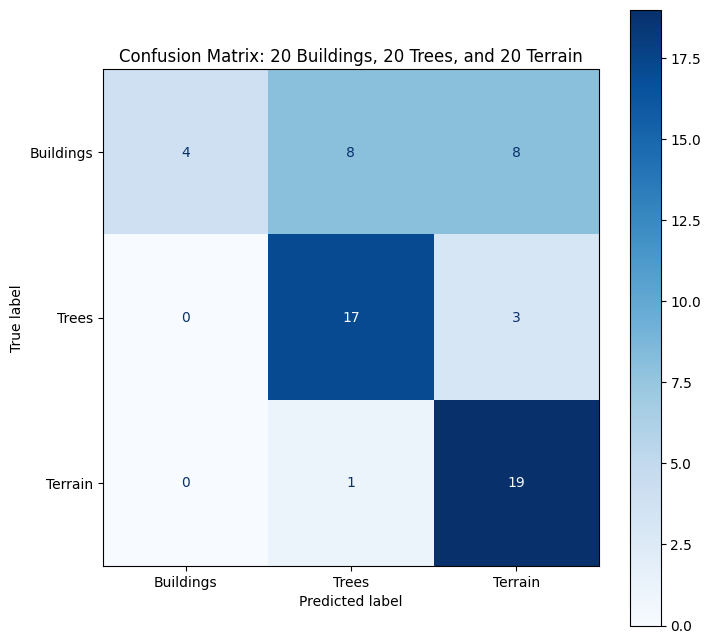

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

# Step 5: Subset 20 Buildings, 20 Trees, and 20 Terrain
buildings_indices = y_test[y_test == 'Buildings'].sample(n=20, random_state=42).index
trees_indices = y_test[y_test == 'Trees'].sample(n=20, random_state=42).index
terrain_indices = y_test[y_test == 'Terrain'].sample(n=20, random_state=42).index

subset_indices = buildings_indices.union(trees_indices).union(terrain_indices)
test_subset = y_test.loc[subset_indices]
pred_subset = pd.Series(y_pred, index=y_test.index).loc[subset_indices]

# Step 6: Confusion matrix calculation
conf_matrix = confusion_matrix(test_subset, pred_subset, labels=['Buildings', 'Trees', 'Terrain'])

# Calculate precision and recall for each class
precision = precision_score(test_subset, pred_subset, labels=['Buildings', 'Trees', 'Terrain'], average=None)
recall = recall_score(test_subset, pred_subset, labels=['Buildings', 'Trees', 'Terrain'], average=None)

# Display precision and recall
print("\nPrecision and Recall for each class:")
classes = ['Buildings', 'Trees', 'Terrain']
for i, cls in enumerate(classes):
    print(f"{cls}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

# Step 7: Print misclassifications
misclassified = test_subset[test_subset != pred_subset]
if not misclassified.empty:
    print("\nMisclassified samples:")
    for idx in misclassified.index:
        print(f"True Class: {test_subset[idx]}, Predicted Class: {pred_subset[idx]}")

# Step 8: Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Buildings', 'Trees', 'Terrain'])
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix: 20 Buildings, 20 Trees, and 20 Terrain")
plt.show()



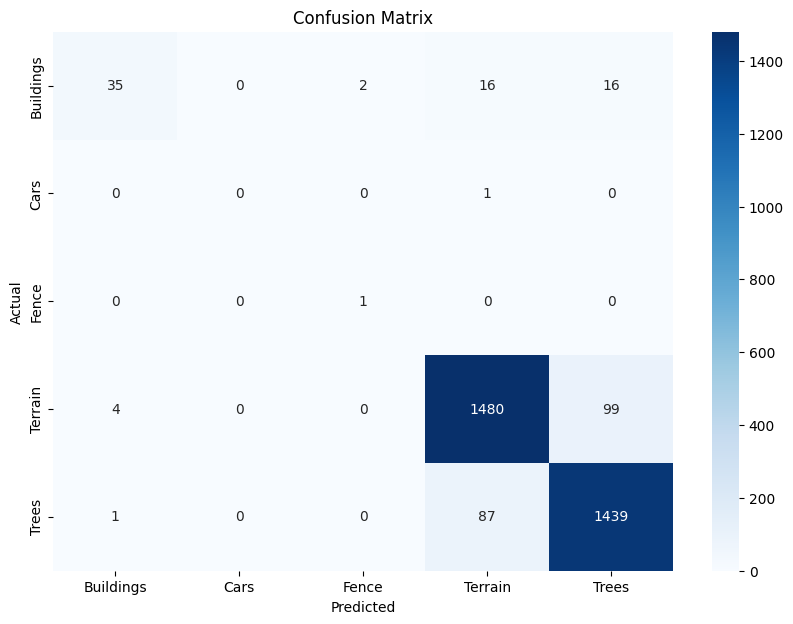

In [181]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Visualising result

In [226]:
import open3d as o3d
import numpy as np

# Define the color mapping for each class
class_colors = {
    1: [1, 0, 0],    # Red
    8: [0, 1, 0],    # Green
    2: [0, 0, 1],    # Blue
    7: [1, 1, 0],    # Yellow
    5: [1, 0, 1],    # Magenta
    4: [0, 1, 1],    # Cyan
}

# Ensure the DataFrame contains the required columns
if {'x', 'y', 'z', 'predicted_class'}.issubset(test_results_df.columns):
    # Extract voxel positions and predicted classes
    voxel_positions = test_results_df[['x', 'y', 'z']].values
    predicted_classes = test_results_df['predicted_class'].values

    # Create a list to hold voxel geometries
    voxel_geometries = []

    # Iterate over each voxel and create a voxel geometry with the corresponding color
    for pos, pred_class in zip(voxel_positions, predicted_classes):
        voxel = o3d.geometry.VoxelGrid.create_from_points(
            o3d.utility.Vector3dVector([pos]), voxel_size=6
        )
        if pred_class in class_colors:
            color = class_colors[pred_class]
        else:
            color = [0.5, 0.5, 0.5]  # Default color for unknown classes

        # Set the voxel color
        voxel.colors = o3d.utility.Vector3dVector([color])
        voxel_geometries.append(voxel)

    # Combine all voxel geometries
    voxel_grid = o3d.geometry.VoxelGrid()
    for voxel in voxel_geometries:
        voxel_grid += voxel

    # Visualize the voxels
    o3d.visualization.draw_geometries([voxel_grid], window_name="Voxel Prediction Visualization")
else:
    print("The DataFrame must include 'x', 'y', 'z', and 'predicted_class' columns.")


The DataFrame must include 'x', 'y', 'z', and 'predicted_class' columns.


### Visualising plot of training set

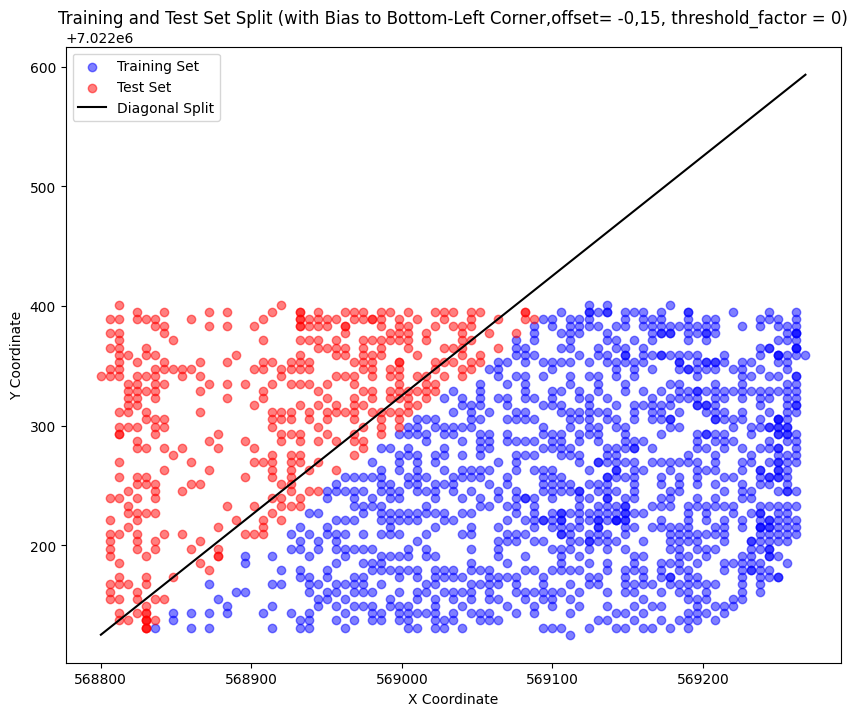

In [39]:
import matplotlib.pyplot as plt

# Step 5: Visualization
plt.figure(figsize=(10, 8))

# Convert voxel indices to coordinates and plot the training set
plt.scatter(
    [v[0] * voxel_size + x_min for v in training_indices],
    [v[1] * voxel_size + y_min for v in training_indices],
    c='blue', label='Training Set', alpha=0.5
)

# Convert voxel indices to coordinates and plot the test set
plt.scatter(
    [v[0] * voxel_size + x_min for v in test_indices],
    [v[1] * voxel_size + y_min for v in test_indices],
    c='red', label='Test Set', alpha=0.5
)

# Plot diagonal line (or modified diagonal)
x_vals = np.linspace(x_min, x_max, 100)
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, color='black', label='Diagonal Split')

# Add labels and title with threshold_factor
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Training and Test Set Split (with Bias to Bottom-Left Corner,offset= -0,15, threshold_factor = {threshold_factor})')

# Display the legend
plt.legend()

# Save the plot to a file
plt.savefig("training_test_split_plot-changed_voz_4_.png")

# Show the plot
plt.show()


### Other1: Training data on classification

In [42]:

# Drop rows with NaN in the target variable (classification)
df_cleaned = df.dropna(subset=['classification'])

# Recalculate training and test indices using cleaned data
features_df_cleaned = pd.DataFrame.from_dict(voxel_features, orient='index')
X_cleaned = features_df_cleaned.drop(columns=['classification'])
y_cleaned = features_df_cleaned['classification']



In [43]:
# Train-test split based on the cleaned data
X_train = X_cleaned.loc[training_indices]
y_train = y_cleaned.loc[training_indices]
X_test = X_cleaned.loc[test_indices]
y_test = y_cleaned.loc[test_indices]



In [44]:
X_train

,,,linearity,planarity,scattering,omnivariance,sum_of_eigenvalues,anisotropy,eigenentropy,change_of_curvature,residual
50,20,4,0.786402,0.213598,1.713899e-20,8.640898e-07,6.804133,1.000000,-9.881305,1.412246e-20,1.933318
74,11,8,0.733857,0.260322,5.821403e-03,3.900878e-01,4.288017,0.994179,-3.922406,4.576703e-03,1.590089
23,7,2,0.615057,0.384509,4.337612e-04,2.533954e-01,6.375058,0.999566,-8.024498,3.130998e-04,1.857756
59,9,3,0.615354,0.384646,1.144090e-20,2.400297e-07,2.028133,1.000000,-0.235788,8.262693e-21,0.988174
53,20,3,0.893333,0.106667,9.276226e-21,2.565569e-07,2.849267,1.000000,-2.079943,8.382127e-21,1.310124
...,...,...,...,...,...,...,...,...,...,...,...
46,7,2,0.945691,0.054309,1.477103e-35,5.777750e-12,6.555900,1.000000,-10.997020,1.401015e-35,2.036041
62,32,2,0.720968,0.279032,2.285865e-22,1.071920e-07,3.431433,1.000000,-2.430863,1.787183e-22,1.337370
64,38,2,0.763643,0.236357,9.960016e-21,1.549691e-06,14.402767,1.000000,-31.390855,8.055935e-21,2.786797
74,40,7,0.870356,0.129644,2.987115e-19,4.079956e-07,1.362267,1.000000,0.064318,2.644297e-19,0.896633


In [45]:
# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the classes for the test set
y_pred = clf.predict(X_test)

In [46]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Mapping for class labels (you can modify this based on your actual class names)
class_labels = {
    0: 'Chimney',
    1: 'Low vegetation',
    2: 'Impervious surfaces',
    3: 'Car',
    4: 'Fence/Hedge',
    5: 'Building',
    6: 'Water',
    7: 'Farm/Soil',
    8: 'Tree'
}

# Create target_names dynamically based on unique classes
target_names = [class_labels[class_idx] for class_idx in unique_classes]

# Now print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report:
                     precision    recall  f1-score   support

     Low vegetation       0.09      0.19      0.12        36
Impervious surfaces       0.10      0.18      0.13        34
        Fence/Hedge       0.00      0.00      0.00         6
           Building       0.00      0.00      0.00         1
          Farm/Soil       0.74      0.39      0.51       255
               Tree       0.45      0.77      0.57        82

           accuracy                           0.43       414
          macro avg       0.23      0.26      0.22       414
       weighted avg       0.56      0.43      0.45       414



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [47]:
# Save to CSV
training_set.to_csv("training_set.csv", index_label="voxel_id")
test_set.to_csv("test_set.csv", index_label="voxel_id")


NameError: name 'training_set' is not defined

In [ ]:
print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")
print(df.head())

x_min: 568800.14, x_max: 569268.19
y_min: 7022124.96, y_max: 7022399.97
           x           y       z  classification  intensity
0  569262.78  7022239.13  212.17               8      47775
1  569025.65  7022374.57  166.45               7      49500
2  569144.93  7022133.95  176.99               2      40413
3  568991.14  7022140.80  169.77               7      48102
4  569017.82  7022268.13  175.62               2      43995


In [48]:
# Print unique classes and their counts in the classification column
print("Unique classes in classification column with their counts:")
print(df['classification'].value_counts())

Unique classes in classification column with their counts:
classification
8    3548
7    3361
1    1810
2    1157
5      92
4      30
3       2
Name: count, dtype: int64


In [49]:
#  Create DataFrames for training and test sets
features_df = pd.DataFrame.from_dict(voxel_features, orient='index')

features_df['is_training'] = features_df.index.map(lambda idx: idx in training_indices)
training_set = features_df[features_df['is_training']]
test_set = features_df[~features_df['is_training']]
classification_summary = features_df.groupby(['classification', 'is_training']).size().unstack(fill_value=0)
print(features_df.head())
print("Classification Summary (Grouped by Training/Test):")
print(classification_summary)

         linearity  planarity    scattering  omnivariance  sum_of_eigenvalues  \
50 20 4   0.786402   0.213598  1.713899e-20  8.640898e-07            6.804133   
74 11 8   0.733857   0.260322  5.821403e-03  3.900878e-01            4.288017   
11 34 3   0.721414   0.278586  6.262639e-08  1.463644e-02            7.215392   
23 7  2   0.615057   0.384509  4.337612e-04  2.533954e-01            6.375058   
59 9  3   0.615354   0.384646  1.144090e-20  2.400297e-07            2.028133   

         anisotropy  eigenentropy  change_of_curvature  residual  \
50 20 4    1.000000     -9.881305         1.412246e-20  1.933318   
74 11 8    0.994179     -3.922406         4.576703e-03  1.590089   
11 34 3    1.000000    -10.476725         4.898099e-08  2.057291   
23 7  2    0.999566     -8.024498         3.130998e-04  1.857756   
59 9  3    1.000000     -0.235788         8.262693e-21  0.988174   

         classification  is_training  
50 20 4               8         True  
74 11 8               8   

## Other

In [13]:
'''
def voxelize_with_constraints(pcd, voxel_size=1.0, max_depth=5, max_points_per_voxel=50):
    # Create an empty octree with the specified max depth
    octree = o3d.geometry.Octree(max_depth=max_depth)
    octree.convert_from_point_cloud(pcd, size_expand=voxel_size)

    # Traverse the octree and apply constraints
    def traverse_and_apply_constraints(node, depth):
        if isinstance(node, o3d.geometry.OctreeInternalNode):
            # Access children directly using the node.children list
            for child in node.children:
                if child is not None:  # Check if child exists
                    traverse_and_apply_constraints(child, depth + 1)
        elif isinstance(node, o3d.geometry.OctreeLeafNode):
            if len(node.indices) > max_points_per_voxel:
                print(f"Voxel at depth {depth} with {len(node.indices)} points exceeds max points threshold.")

    traverse_and_apply_constraints(octree.root_node, depth=0)
    return octree

# Apply constrained voxelization
voxel_size = 1.0       # Minimum voxel size
max_depth = 5          # Maximum depth of the octree
max_points_per_voxel = 100  # Maximum points allowed in a voxel

octree = voxelize_with_constraints(pcd, voxel_size, max_depth, max_points_per_voxel)
'''

Voxel at depth 5 with 123 points exceeds max points threshold.
Voxel at depth 5 with 145 points exceeds max points threshold.
Voxel at depth 5 with 106 points exceeds max points threshold.
Voxel at depth 5 with 110 points exceeds max points threshold.
Voxel at depth 5 with 105 points exceeds max points threshold.
Voxel at depth 5 with 103 points exceeds max points threshold.
Voxel at depth 5 with 145 points exceeds max points threshold.


In [ ]:
#Visualising octtree
#o3d.visualization.draw_geometries([octree], window_name="Constrained Voxelized Octree")


In [ ]:
#Visualising voxel
#o3d.visualization.draw_geometries([voxel_grid], window_name="Voxel Grid Visualization", width=800, height=600)


In [12]:
# Step 2 & 3: Feature Selection and Calculation
# Extract voxel-based features: mean, std dev of intensity within each voxel
df['voxel_id'] = df[['x', 'y', 'z']].apply(lambda row: tuple(voxel_grid.get_voxel(np.array(row))), axis=1)

# Group by voxel ID and calculate desired statistics
voxel_features = df.groupby('voxel_id').agg({
    'intensity': ['mean', 'std'],
    'x': 'mean', 'y': 'mean', 'z': 'mean'
}).fillna(0)

# Flatten the MultiIndex columns
voxel_features.columns = ['_'.join(col) for col in voxel_features.columns]

In [14]:
features = voxel_features
labels = df.groupby('voxel_id')['classification'].first()

In [15]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize and train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate classifier
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.83      0.84       441
           2       0.89      0.89      0.89       259
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       1.00      0.62      0.76        26
           7       0.94      0.97      0.95       771
           8       0.94      0.94      0.94       882

    accuracy                           0.92      2386
   macro avg       0.66      0.61      0.63      2386
weighted avg       0.91      0.92      0.92      2386



/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Rebekka/miniconda3/envs/minimal_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Other 2

# The classes need to be labeled for TBA-4256
# scalar field name: class
########
0 Chimney
1 Low vegetation
2 Impervious surfaces
3 Car
4 Fence/Hedge
5 Building
6 Water
7 Farm/Soil
8 Tree